In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import datetime
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, precision_score
from sklearn.metrics import f1_score
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/df_eda.pkl', 'rb') as f:
    data=pickle.load(f)
df_org=pd.DataFrame(data)
df_org.head()

,Title,Body,Tags
1,good branching merge tutorial tortoisesvn,really good tutorial explain branch merge apac...,[svn]
2,asp net site map,anyone get experience create sqlbased asp net ...,"[sql, asp.net]"
3,function create color wheel,something pseudosolved many time never quite f...,[algorithm]
4,add script functionality net application,little game write c us database backend tradin...,"[c#, .net]"
5,use nested class case,work collection class use video playback recor...,"[c++, oop]"


In [ ]:
df_org.shape

(80393, 3)

In [ ]:
df_org['Tags_n'] = df_org['Tags'].apply(lambda x: ' '.join(map(str, x)))


In [ ]:
df_org.head()

,Title,Body,Tags,Tags_n
1,good branching merge tutorial tortoisesvn,really good tutorial explain branch merge apac...,[svn],svn
2,asp net site map,anyone get experience create sqlbased asp net ...,"[sql, asp.net]",sql asp.net
3,function create color wheel,something pseudosolved many time never quite f...,[algorithm],algorithm
4,add script functionality net application,little game write c us database backend tradin...,"[c#, .net]",c# .net
5,use nested class case,work collection class use video playback recor...,"[c++, oop]",c++ oop


In [ ]:

texts=df_org['Title']+" "+df_org['Body']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(texts, df_org['Tags_n'], test_size=0.2,random_state=42)


In [ ]:

start = datetime.now()
vectorizerTF = TfidfVectorizer(min_df=0.00009, max_features=10000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizerTF.fit_transform(Train_X)
x_test_multilabel = vectorizerTF.transform(Test_X)

print("Time taken to run this cell :", datetime.now() - start)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time taken to run this cell : 0:00:49.879035


In [ ]:
x_train_multilabel

<64314x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3474265 stored elements in Compressed Sparse Row format>

In [ ]:
start = datetime.now()
vectorizerCV = CountVectorizer(tokenizer = lambda x: x.split(), binary=True,max_features=1500)
y_train_multilabel = vectorizerCV.fit_transform(Train_Y)
y_test_multilabel = vectorizerCV.transform(Test_Y)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.225978


In [ ]:
print("Number of data points of in ytrain: ",y_train_multilabel.shape)
print("Number of data points of in ytest: ",y_test_multilabel.shape)

Number of data points of in ytrain:  (64314, 100)
Number of data points of in ytest:  (16079, 100)


In [ ]:
print("Number of data points of in xtrain: ",x_train_multilabel.shape)
print("Number of data points of in xtest: ",x_test_multilabel.shape)

Number of data points of in xtrain:  (64314, 10000)
Number of data points of in xtest:  (16079, 10000)


In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train_multilabel)
predictions = classifier.predict(x_test_multilabel)
print("accuracy :",accuracy_score(y_test_multilabel,predictions))
print("macro f1 score :",f1_score(y_test_multilabel, predictions, average = 'macro'))
print("micro f1 scoore :",f1_score(y_test_multilabel, predictions, average = 'micro'))
print("hamming loss :",hamming_loss(y_test_multilabel,predictions))
print("Precision recall report :\n",classification_report(y_test_multilabel, predictions))

In [ ]:
predictions

<16079x100 sparse matrix of type '<class 'numpy.int64'>'
	with 16905 stored elements in Compressed Sparse Row format>

In [ ]:
def cleaning(text):
    text = text.lower()
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean = re.compile('<.*?>')
    text = re.sub(clean,'',text)
    text = pattern.sub('', text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)

    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    text = ' '.join(words)
    return text

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
test = "This is a java question. Array index out of bound."
test = [cleaning(test)]
test = vectorizerTF.transform(test)
pred = classifier.predict(test)
predicted_tags = vectorizerCV.inverse_transform(pred)
predicted_tags_content = str(predicted_tags[0])

print("Predicted tag(s):", predicted_tags_content)


Predicted tag(s): ['java']


In [ ]:
test="Android dependency android.arch.lifecycle:runtime has different version for the compile (1.0.0) and runtime (1.1.1) classpath"
test = [cleaning(test)]
test = vectorizerTF.transform(test)
pred = classifier.predict(test)
predicted_tags = vectorizerCV.inverse_transform(pred)

print("Predicted tag(s):", predicted_tags)

Predicted tag(s): [array(['android'], dtype='<U18')]


In [ ]:
df_org.head()

,Title,Body,Tags,Tags_n
1,good branching merge tutorial tortoisesvn,really good tutorial explain branch merge apac...,[svn],svn
2,asp net site map,anyone get experience create sqlbased asp net ...,"[sql, asp.net]",sql asp.net
3,function create color wheel,something pseudosolved many time never quite f...,[algorithm],algorithm
4,add script functionality net application,little game write c us database backend tradin...,"[c#, .net]",c# .net
5,use nested class case,work collection class use video playback recor...,"[c++, oop]",c++ oop


In [ ]:
df_org['Tags_nn'] = df_org['Tags_n'].apply(lambda x: x.split())

In [ ]:
flat_list = [item for sublist in df_org['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [ ]:
len(tags_features)

100

In [ ]:
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 'ios',
 '.net',
 'html',
 'css',
 'c',
 'objective-c',
 'iphone',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'asp.net-mvc',
 'git',
 'linux',
 'sql-server',
 'angularjs',
 'node.js',
 'django',
 'algorithm',
 'performance',
 'arrays',
 'wpf',
 'string',
 'xcode',
 'eclipse',
 'windows',
 'scala',
 'haskell',
 'multithreading',
 'regex',
 'json',
 'c++11',
 'html5',
 'osx',
 'swift',
 'visual-studio',
 'database',
 'spring',
 'xml',
 'unit-testing',
 'bash',
 'ajax',
 'delphi',
 'linq',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'winforms',
 'perl',
 'entity-framework',
 'generics',
 'cocoa-touch',
 'debugging',
 'mongodb',
 'cocoa',
 'security',
 'postgresql',
 'templates',
 'css3',
 'google-chrome',
 'oracle',
 'image',
 'list',
 'twitter-bootstrap',
 'oop',
 'hibernate',
 'facebook',
 'maven',
 'vim',
 'shell',
 'gcc',
 'asp.net-mvc-3',
 'rest',
 'numpy',
 'qt',
 'tsql',
 'exceptio

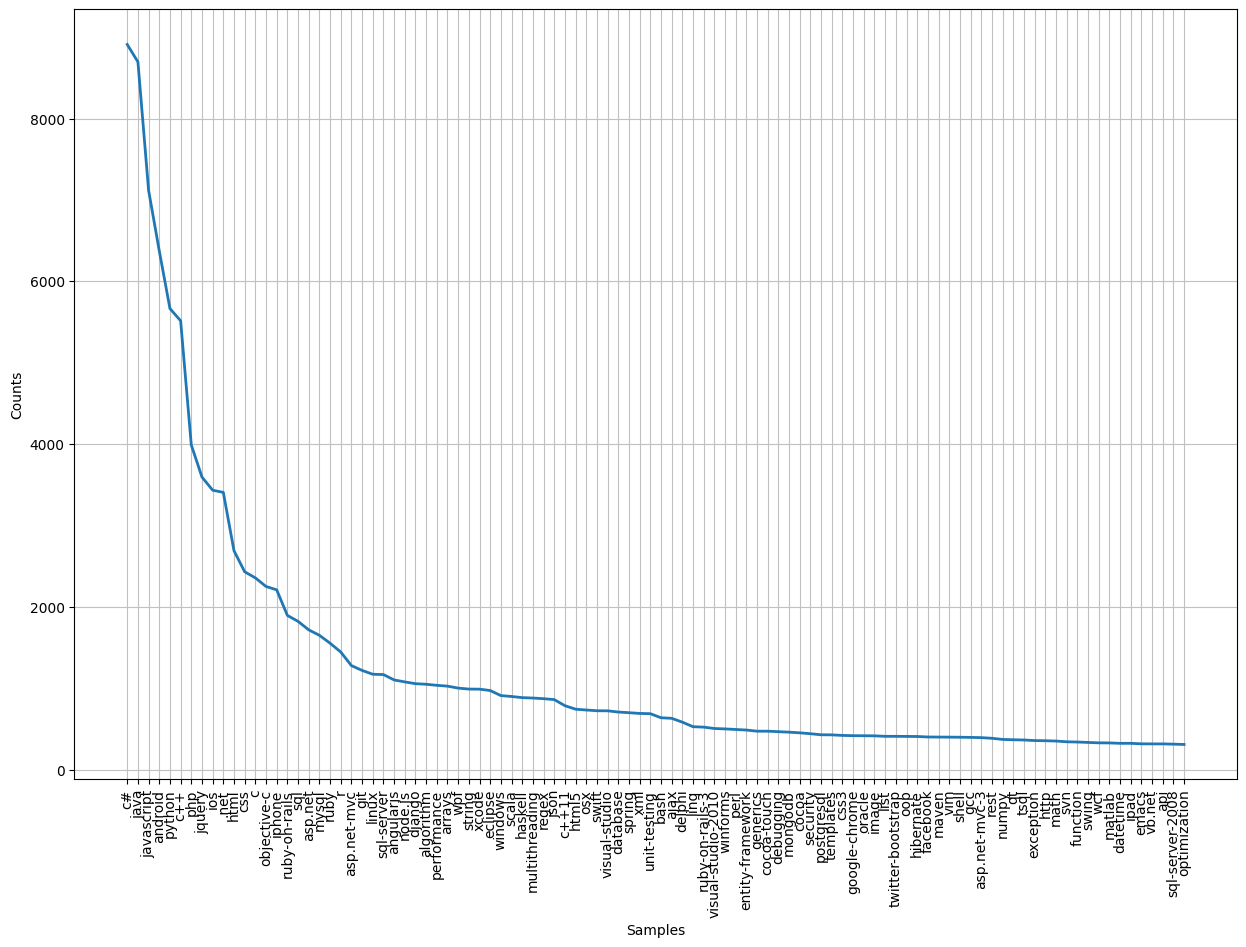

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [ ]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [ ]:
df_org['Tags'] = df_org['Tags'].apply(lambda x: most_common(x))
df_org['Tags'] = df_org['Tags'].apply(lambda x: x if len(x)>0 else None)

In [ ]:
X1=df_org['Title']
X2=df_org['Body']

In [ ]:
y=df_org['Tags']
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [ ]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [ ]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [ ]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [ ]:
import os
def get_scores(y_pred, y_true):
    jacard = np.minimum(y_test, y_pred).sum(axis=1) / np.maximum(y_true, y_pred).sum(axis=1)
    jacard_score = jacard.mean()
    hamming = hamming_loss(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='micro')
    accuracy = metrics.accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_score = report['micro avg']['f1-score']
    return {'Jacard Score': jacard_score, 'Hamming Loss': hamming, 'Precision': precision,'Accuracy': accuracy ,'F1 Score': f1_score}


sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
Scores={}
folder_path = "/content/drive/MyDrive/Colab Notebooks/ISR"
classifiers = [sgd, lr, mn, svc, perceptron, pac]
classifier_names = ['SGD_Weight.pkl', 'LR_Weight.pkl', 'MN_Weight.pkl', 'SVC_Weight.pkl', 'Perceptron_Weight.pkl', 'PAC_Weight.pkl']

for classifier, classifier_name in zip(classifiers, classifier_names):
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Scores[classifier.__class__.__name__] = get_scores(y_pred, y_test)
    if hasattr(clf.estimator, 'coef_'):
        # For classifiers with coefficients
        weights = clf.estimator.coef_
    else:
        # For classifiers without coefficients
        weights = None

    # Save the classifier with weights to a pickle file
    file_path = os.path.join(folder_path, classifier_name)
    with open(file_path, 'wb') as f:
        pickle.dump(clf, f)

scores_df = pd.DataFrame(Scores).transpose()
# print(scores_df)


In [58]:
scores_df

,Jacard Score,Hamming Loss,Precision,Accuracy,F1 Score
SGDClassifier,0.454468,0.993097,0.880424,0.332919,0.576648
LogisticRegression,0.473161,0.996268,0.827345,0.336339,0.595919
MultinomialNB,0.393277,1.209528,0.682722,0.249269,0.532050
LinearSVC,0.505875,0.984016,0.797062,0.355681,0.618103
Perceptron,0.447601,1.498476,0.524564,0.249767,0.529947
PassiveAggressiveClassifier,0.480841,1.310094,0.592794,0.291623,0.566037


In [68]:
from sklearn.multioutput import MultiOutputClassifier
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
Scores_n={}

for classifier in [sgd, lr, mn, svc, perceptron, pac]:
    clf = CalibratedClassifierCV(classifier)
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Scores_n[classifier.__class__.__name__] = get_scores(y_pred, y_test)

scores_df_n = pd.DataFrame(Scores_n).transpose()



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples wi

In [70]:
scores_df_n

,Jacard Score,Hamming Loss,Precision,Accuracy,F1 Score
SGDClassifier,0.497162,0.955532,0.845039,0.358853,0.614551
LogisticRegression,0.497237,0.980098,0.807110,0.351825,0.615700
MultinomialNB,0.398345,1.150258,0.742980,0.266186,0.531831
LinearSVC,0.481965,0.987002,0.839143,0.347845,0.596860
Perceptron,0.389892,1.091921,0.896356,0.288513,0.501462
PassiveAggressiveClassifier,0.416893,1.057715,0.883969,0.306735,0.530854
